In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL)
2

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev&mel_aug_Batch_Norm_focal"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [7]:
#Initializing ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 3s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
#Adding additional layers to ViT
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [9]:
#Function for focal loss
def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# compile model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)       #Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                         #Confguring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
#function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)           #classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')          #calculate precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/kaggle/input/isic-train-merge-aug/train_merged_augumented-2023/train_merged_augumented/task2"
test_dir = "/kaggle/input/isic-train-merge-aug/test2023/test/task2"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [16]:
model_path = f'/kaggle/working/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.5279
Epoch 1: val_accuracy improved from -inf to 0.58846, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_1.hdf5
104/104 [==============================] - 107s 483ms/step - loss: 0.1773 - accuracy: 0.5279 - val_loss: 0.0931 - val_accuracy: 0.5885 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.5452
Epoch 2: val_accuracy improved from 0.58846 to 0.66923, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_1.hdf5
104/104 [======================

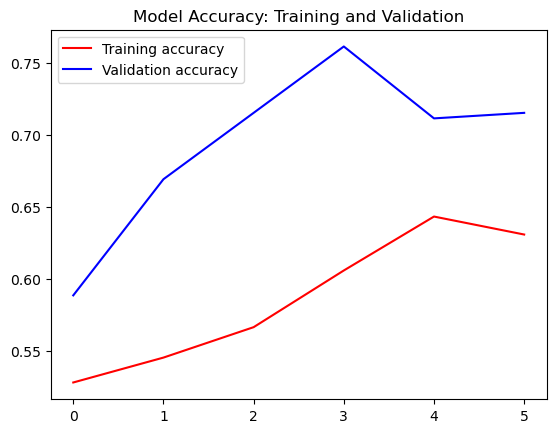

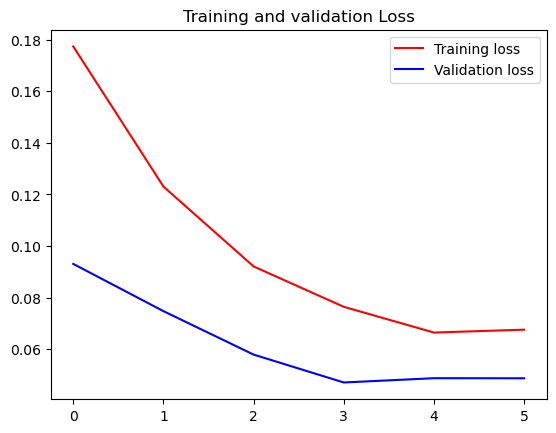

<Figure size 640x480 with 0 Axes>

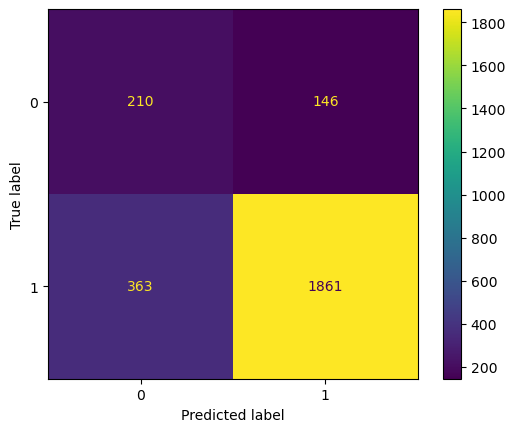


               precision    recall  f1-score   support

           0       0.37      0.59      0.45       356
           1       0.93      0.84      0.88      2224

    accuracy                           0.80      2580
   macro avg       0.65      0.71      0.67      2580
weighted avg       0.85      0.80      0.82      2580

Sensitivity: 0.837 Specificity: 0.59 Precision: 0.85 ROC_AUC_SCORE: 0.792



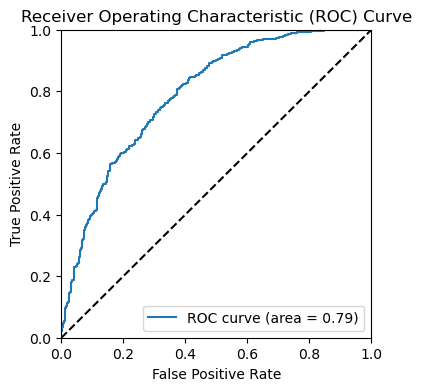

Validation complete...
Traning for Fold: 2
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.6519
Epoch 1: val_accuracy improved from -inf to 0.80385, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_2.hdf5
104/104 [==============================] - 103s 534ms/step - loss: 0.0654 - accuracy: 0.6519 - val_loss: 0.0406 - val_accuracy: 0.8038 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.6452
Epoch 2: val_accuracy improved from 0.80385 to 0.81154, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_2.hdf5
104/104 

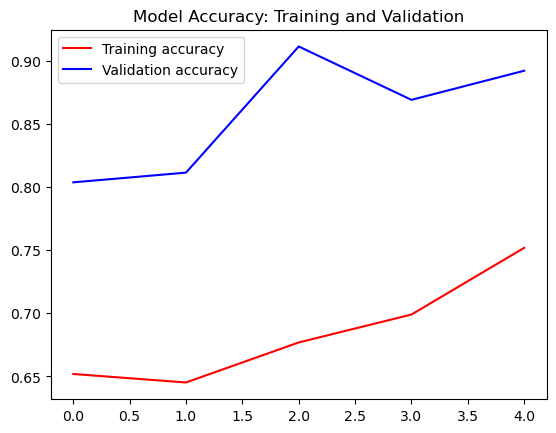

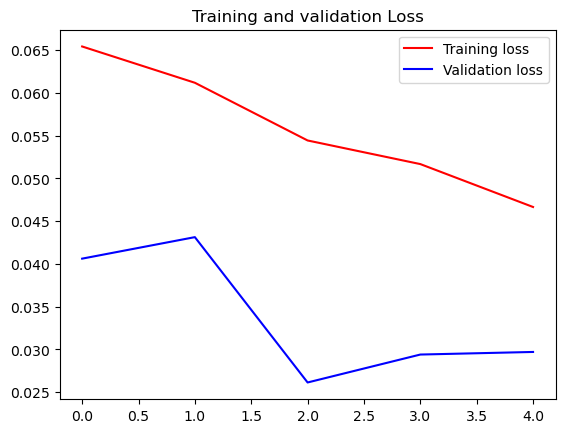

<Figure size 640x480 with 0 Axes>

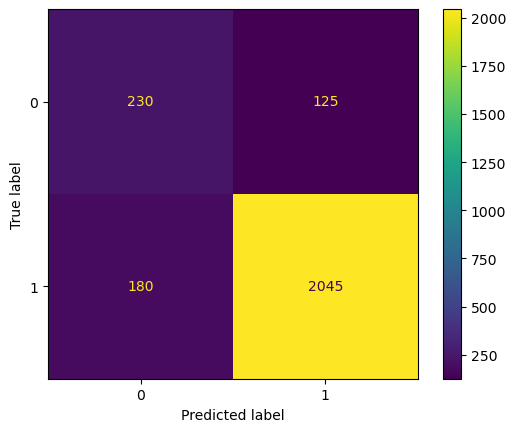


               precision    recall  f1-score   support

           0       0.56      0.65      0.60       355
           1       0.94      0.92      0.93      2225

    accuracy                           0.88      2580
   macro avg       0.75      0.78      0.77      2580
weighted avg       0.89      0.88      0.89      2580

Sensitivity: 0.919 Specificity: 0.648 Precision: 0.89 ROC_AUC_SCORE: 0.891



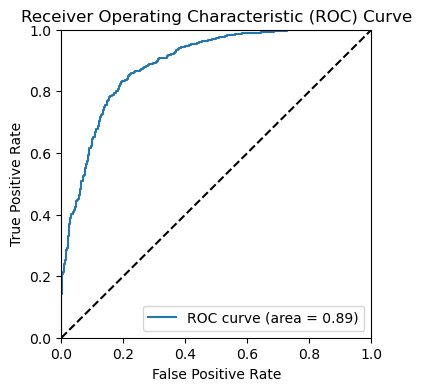

Validation complete...
Traning for Fold: 3
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.7298
Epoch 1: val_accuracy improved from -inf to 0.83077, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_3.hdf5
104/104 [==============================] - 102s 537ms/step - loss: 0.0543 - accuracy: 0.7298 - val_loss: 0.0389 - val_accuracy: 0.8308 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.6952
Epoch 2: val_accuracy improved from 0.83077 to 0.92308, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_3.hdf5
104/104 

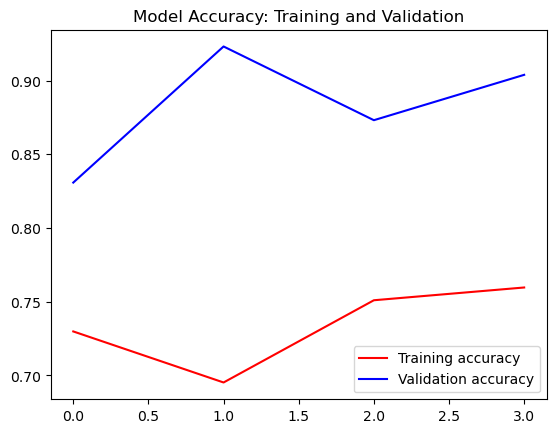

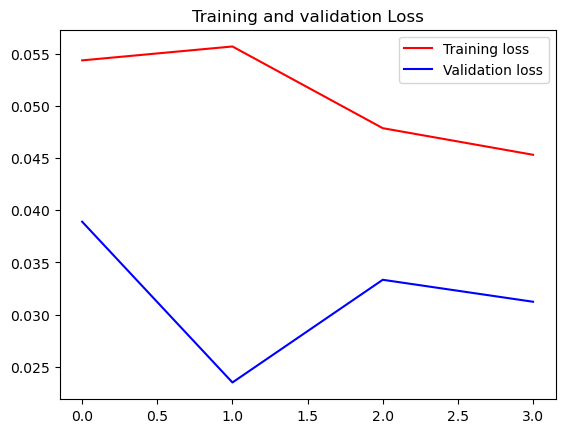

<Figure size 640x480 with 0 Axes>

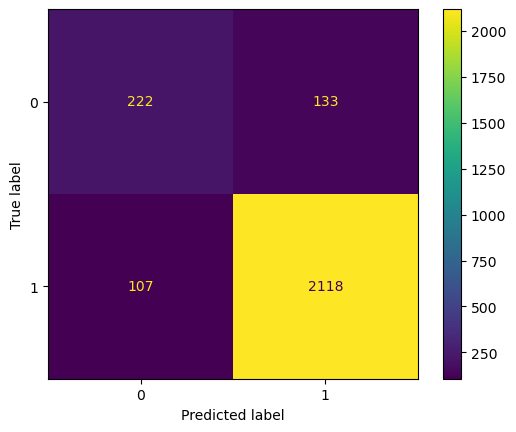


               precision    recall  f1-score   support

           0       0.67      0.63      0.65       355
           1       0.94      0.95      0.95      2225

    accuracy                           0.91      2580
   macro avg       0.81      0.79      0.80      2580
weighted avg       0.90      0.91      0.91      2580

Sensitivity: 0.952 Specificity: 0.625 Precision: 0.904 ROC_AUC_SCORE: 0.887



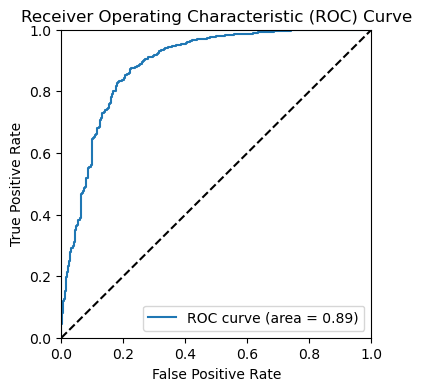

Validation complete...
Traning for Fold: 4
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.7260
Epoch 1: val_accuracy improved from -inf to 0.91923, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_4.hdf5
104/104 [==============================] - 104s 550ms/step - loss: 0.0499 - accuracy: 0.7260 - val_loss: 0.0246 - val_accuracy: 0.9192 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.7433
Epoch 2: val_accuracy did not improve from 0.91923
104/104 [==============================] - 50s 483ms/step - loss: 0.0478 - accuracy: 0.7433 - val_loss: 0

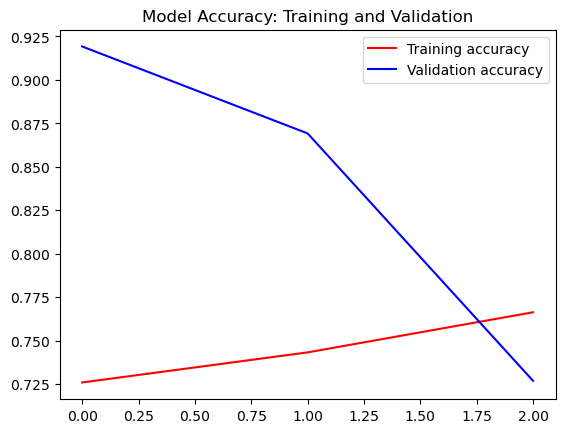

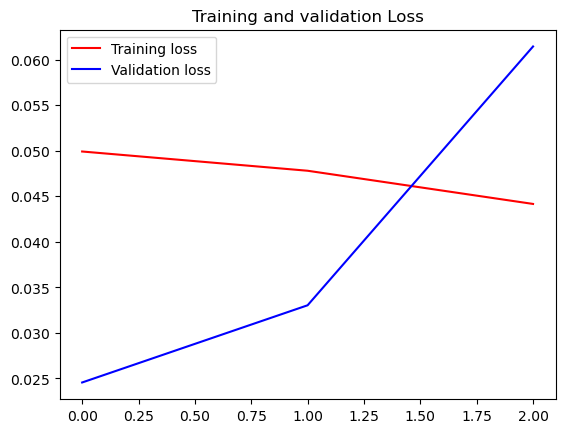

<Figure size 640x480 with 0 Axes>

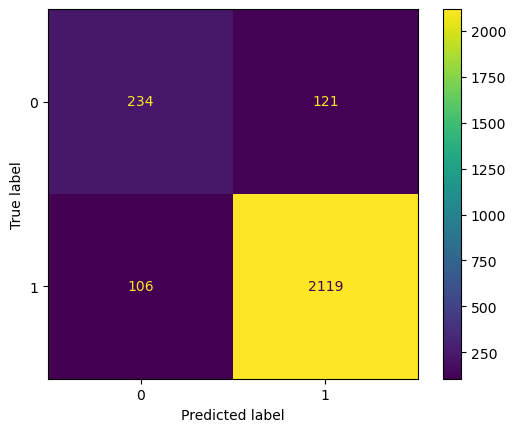


               precision    recall  f1-score   support

           0       0.69      0.66      0.67       355
           1       0.95      0.95      0.95      2225

    accuracy                           0.91      2580
   macro avg       0.82      0.81      0.81      2580
weighted avg       0.91      0.91      0.91      2580

Sensitivity: 0.952 Specificity: 0.659 Precision: 0.911 ROC_AUC_SCORE: 0.893



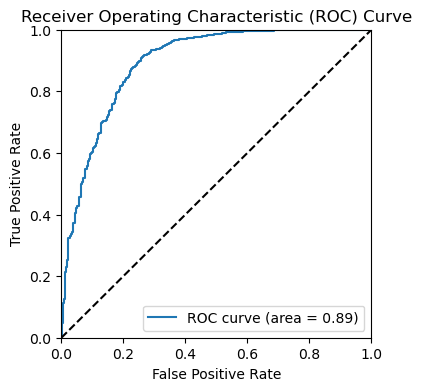

Validation complete...
Traning for Fold: 5
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.7596
Epoch 1: val_accuracy improved from -inf to 0.92308, saving model to /kaggle/working/model/seb_vs_nev&mel_aug_Batch_Norm_focal/model_fold_5.hdf5
104/104 [==============================] - 103s 545ms/step - loss: 0.0466 - accuracy: 0.7596 - val_loss: 0.0280 - val_accuracy: 0.9231 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.7596
Epoch 2: val_accuracy did not improve from 0.92308
104/104 [==============================] - 51s 487ms/step - loss: 0.0479 - accuracy: 0.7596 - val_loss: 0

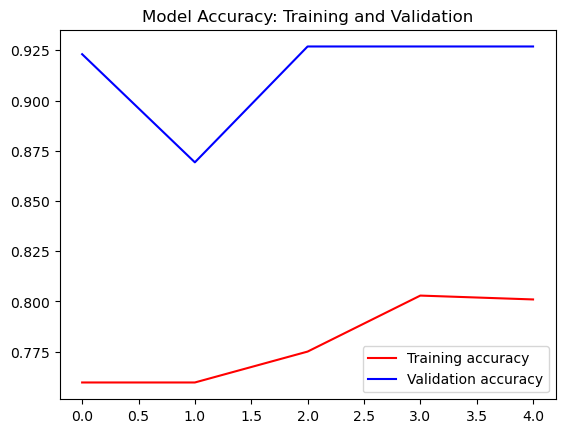

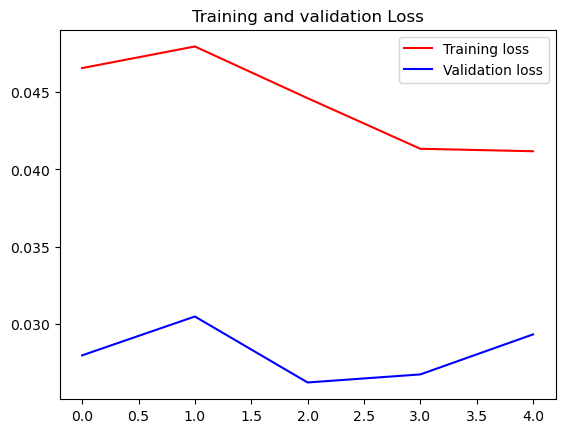

<Figure size 640x480 with 0 Axes>

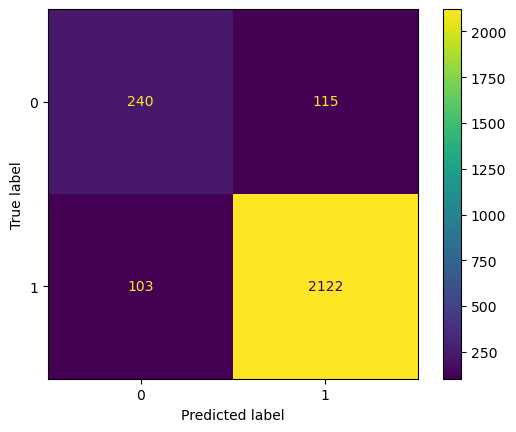


               precision    recall  f1-score   support

           0       0.70      0.68      0.69       355
           1       0.95      0.95      0.95      2225

    accuracy                           0.92      2580
   macro avg       0.82      0.81      0.82      2580
weighted avg       0.91      0.92      0.91      2580

Sensitivity: 0.954 Specificity: 0.676 Precision: 0.914 ROC_AUC_SCORE: 0.913



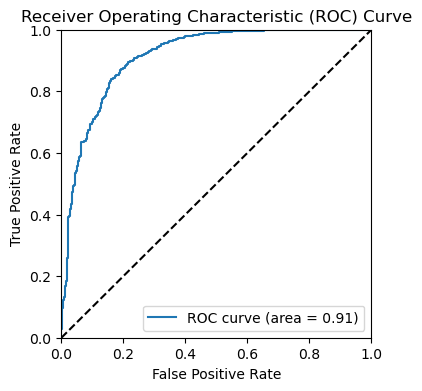

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    #Model is evaluating using ths=is validation generator by making shuffle = False
    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=10,
        callbacks=callbacks)

    graph_it(history)

    # Evaluate the model on the this test data generator
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


In [18]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 25s 41ms/step


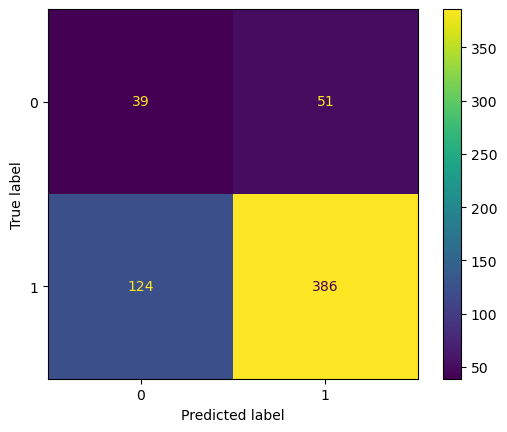


               precision    recall  f1-score   support

           0       0.24      0.43      0.31        90
           1       0.88      0.76      0.82       510

    accuracy                           0.71       600
   macro avg       0.56      0.60      0.56       600
weighted avg       0.79      0.71      0.74       600

Sensitivity: 0.757 Specificity: 0.433 Precision: 0.787 ROC_AUC_SCORE: 0.627



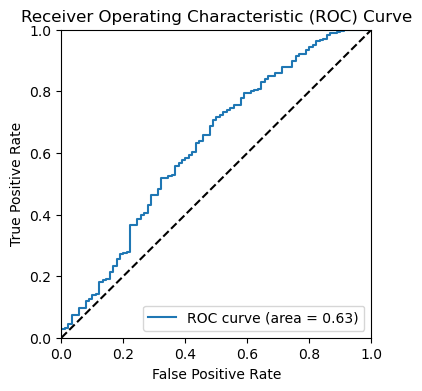

Testing Complete
Test using model 2
600/600 [==============================] - 25s 42ms/step


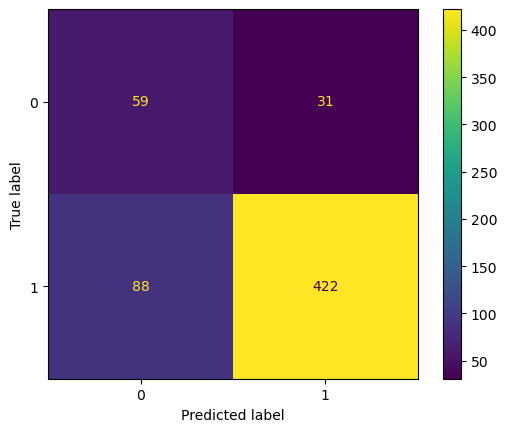


               precision    recall  f1-score   support

           0       0.40      0.66      0.50        90
           1       0.93      0.83      0.88       510

    accuracy                           0.80       600
   macro avg       0.67      0.74      0.69       600
weighted avg       0.85      0.80      0.82       600

Sensitivity: 0.827 Specificity: 0.656 Precision: 0.852 ROC_AUC_SCORE: 0.825



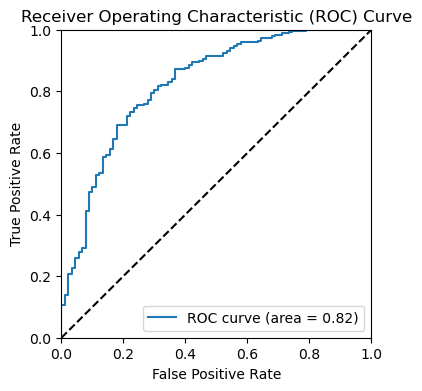

Testing Complete
Test using model 3
600/600 [==============================] - 24s 41ms/step


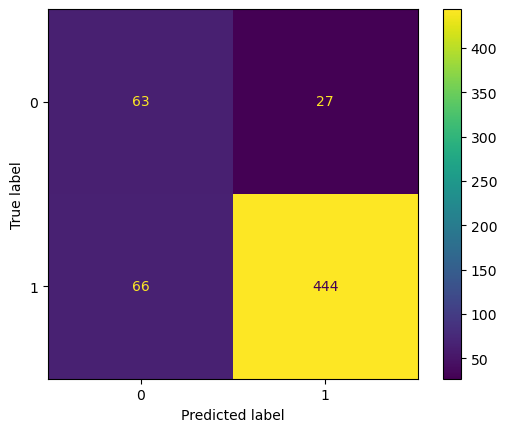


               precision    recall  f1-score   support

           0       0.49      0.70      0.58        90
           1       0.94      0.87      0.91       510

    accuracy                           0.84       600
   macro avg       0.72      0.79      0.74       600
weighted avg       0.87      0.84      0.86       600

Sensitivity: 0.871 Specificity: 0.7 Precision: 0.875 ROC_AUC_SCORE: 0.881



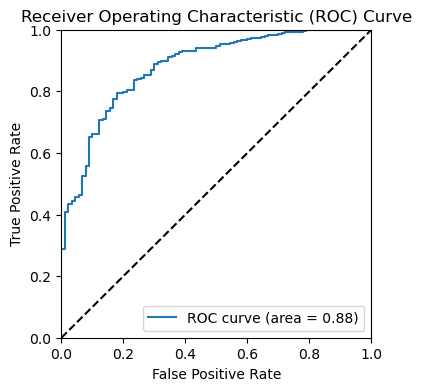

Testing Complete
Test using model 4
600/600 [==============================] - 24s 41ms/step


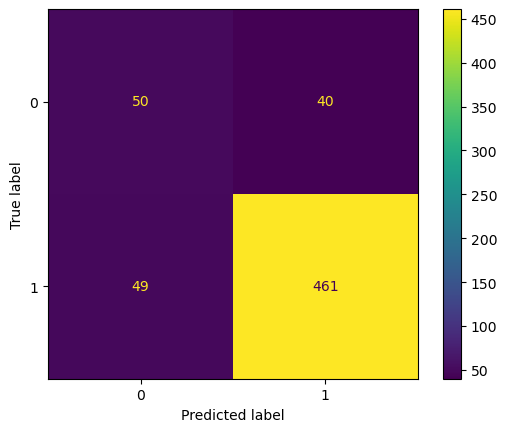


               precision    recall  f1-score   support

           0       0.51      0.56      0.53        90
           1       0.92      0.90      0.91       510

    accuracy                           0.85       600
   macro avg       0.71      0.73      0.72       600
weighted avg       0.86      0.85      0.85       600

Sensitivity: 0.904 Specificity: 0.556 Precision: 0.858 ROC_AUC_SCORE: 0.841



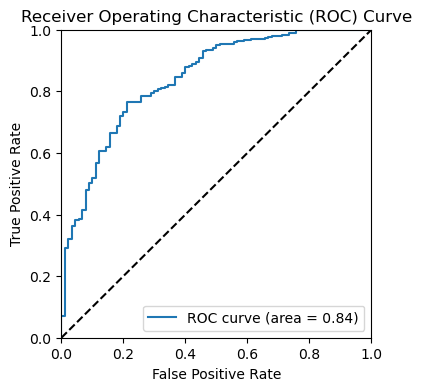

Testing Complete
Test using model 5
600/600 [==============================] - 25s 42ms/step


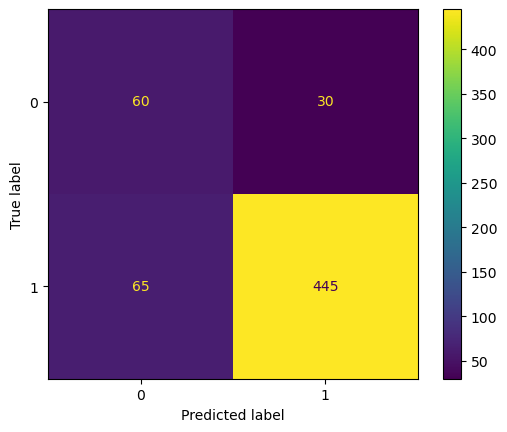


               precision    recall  f1-score   support

           0       0.48      0.67      0.56        90
           1       0.94      0.87      0.90       510

    accuracy                           0.84       600
   macro avg       0.71      0.77      0.73       600
weighted avg       0.87      0.84      0.85       600

Sensitivity: 0.873 Specificity: 0.667 Precision: 0.868 ROC_AUC_SCORE: 0.878



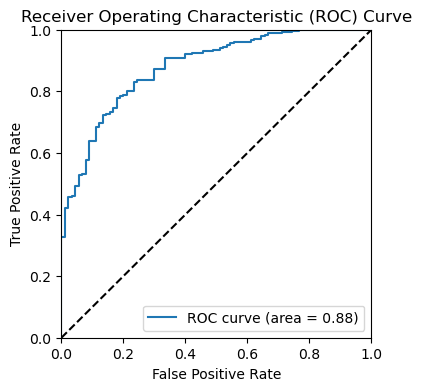

Testing Complete


In [19]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")